In [1]:
%pylab inline

from importlib import reload

import scipy
from scipy import interpolate
import skimage

import torch

import model, spline
from model import renderer

Populating the interactive namespace from numpy and matplotlib


(48, 32)


C:\Users\Kenny\AppData\Local\Temp/ipykernel_16216/1027288082.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = skimage.data.human_mitosis()[112:160, 96:128].astype(np.float)


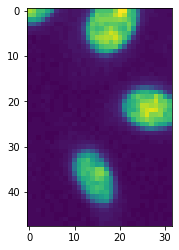

In [2]:
image = skimage.data.human_mitosis()[112:160, 96:128].astype(np.float)
imshow(image)
print(image.shape)

Fitting...


C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


Final loss: 0.855	R2: 0.998


C:\Users\Kenny\AppData\Local\Temp/ipykernel_16216/1465327210.py:12: RuntimeWarning: divide by zero encountered in log10
  im = axes[2].imshow(np.log10(image_interpolated-image))
C:\Users\Kenny\AppData\Local\Temp/ipykernel_16216/1465327210.py:12: RuntimeWarning: invalid value encountered in log10
  im = axes[2].imshow(np.log10(image_interpolated-image))


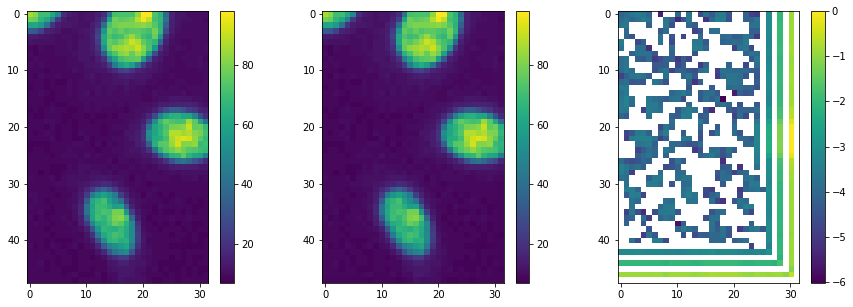

In [3]:
reload(renderer)
# spline_model = spline.Spline2D(image, k=3, fit_image=False)
spline_model = renderer.Spline2DRenderer(image.shape, [], k=3, template_init=image)

image_interpolated = spline_model.render(1)

fig, axes = subplots(1, 3, figsize=(15, 5))
im = axes[0].imshow(image)
colorbar(im, ax=axes[0])
im = axes[1].imshow(image_interpolated)
colorbar(im, ax=axes[1])
im = axes[2].imshow(np.log10(image_interpolated-image))
colorbar(im, ax=axes[2])

Fitting...
Final loss: 0.855	R2: 0.998


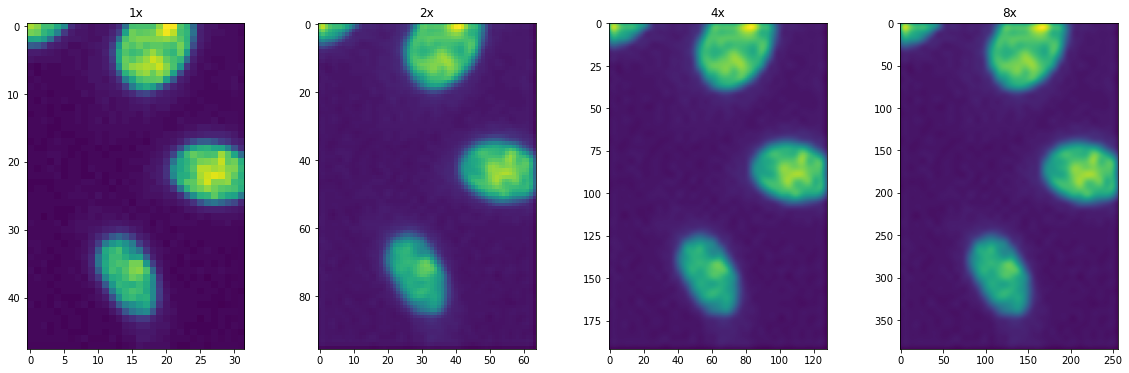

In [4]:
reload(renderer)
# spline_model = spline.Spline2D(image, k=3, fit_image=True)
spline_model = renderer.Spline2DRenderer(image.shape, [], k=3, template_init=image)

image_interpolated = spline_model.render(1)

fig, axes = subplots(1, 4, figsize=(20, 6))
for i in range(4):
    axes[i].imshow(spline_model.render(2**i))
    axes[i].set_title("{}x".format(2**i))

(48, 32)
Fitting...
Final loss: 0.855	R2: 0.998


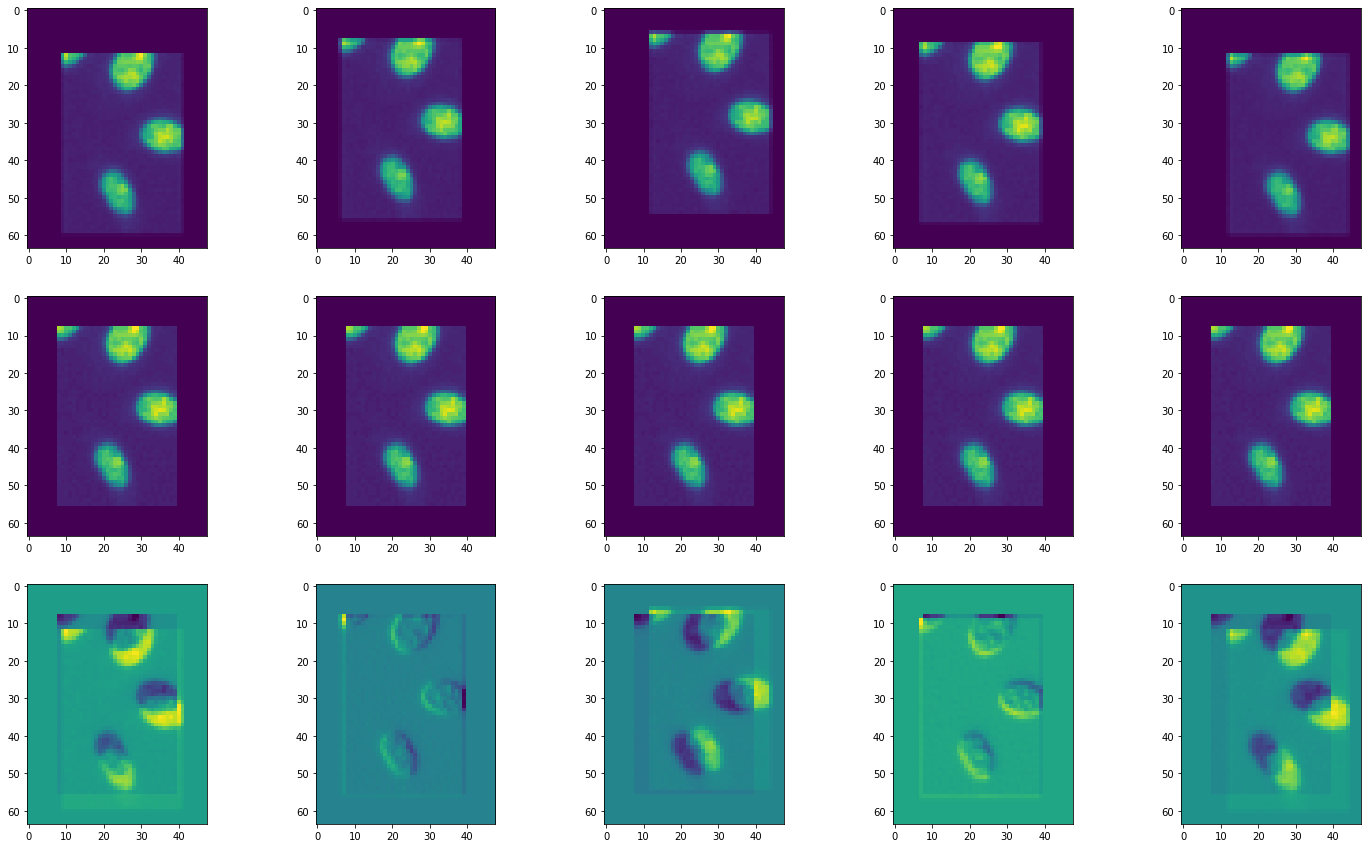

In [5]:
reload(renderer)
print(image.shape)
# spline_model = spline.Spline2D(image, k=3, out_size=(64,64), fit_image=True)
padding=8
spline_model = renderer.Spline2DRenderer([dim+2*padding for dim in image.shape], [], k=3, template_init=image)

x = dict()
x['x'] = (torch.rand((128, 1, 1, 1)) - 0.5) * 10
x['y'] = (torch.rand((128, 1, 1, 1)) - 0.5) * 10
x['A'] = 1
x['bg'] = 0
image_interpolated = spline_model(x).detach().numpy()

n = 5
fig, axes = subplots(3, n, figsize=(5*n, 5*3))
for i, j in enumerate(np.linspace(0, image_interpolated.shape[2]-1, n)):    
    j = int(floor(j))
    
    axes[0,i].imshow(image_interpolated[j,0,:,:])
    # z_index = min(int(floor(x['z'][j])), volume.shape[2]-1)
    groundtruth = np.pad(image, ((padding,)*2, (padding,)*2))
    axes[1,i].imshow(groundtruth)
    axes[2,i].imshow(image_interpolated[j,0,:,:]-groundtruth)

In [6]:
reload(spline)
spline.test_calculate_bspline_basis_fast_mode()

PASSED all 1000 runs.


(128, 128, 30)


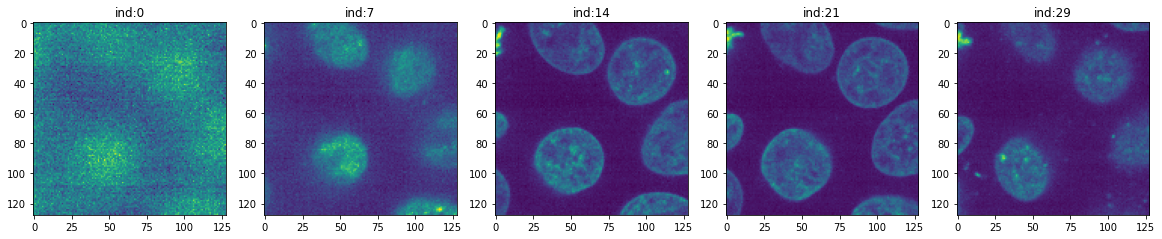

In [7]:
volume = skimage.data.cells3d()[15:-15,1,64:-64,64:-64].astype(np.float32)
volume = np.moveaxis(volume, 0, -1)
print(volume.shape)

n=5
fig, axes = subplots(1, n, figsize=(4*n, 4))
for i, j in enumerate(np.linspace(0, volume.shape[2]-1, n)):
    j = np.floor(j).astype(int)
    axes[i].imshow(volume[:,:,j])
    axes[i].set_title("ind:{}".format(j))

  0%|          | 0/10 [00:00<?, ?it/s]

Final loss: 579780.625	R2: 0.979


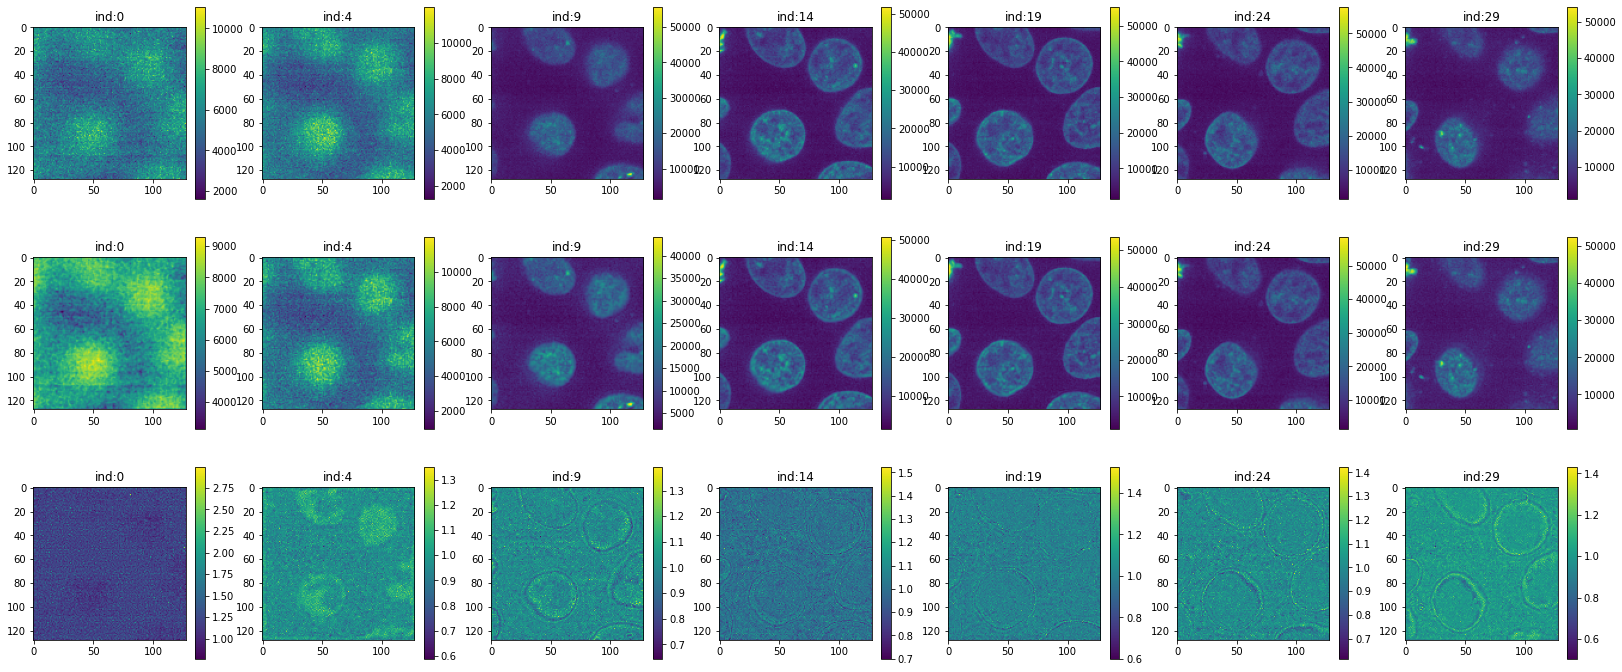

In [8]:
reload(renderer)
spline_model = renderer.Spline3DRenderer(volume.shape[:2], [], k=3, template_init=volume)

volume_interpolated = spline_model.render(1).detach().numpy()

n = 7
fig, axes = subplots(3, n, figsize=(n*4, 3*4))
for i, j in enumerate(np.linspace(0, volume.shape[2]-1, n)):
    j = int(floor(j))
    
    im=axes[0,i].imshow(volume[:,:,j])
    colorbar(im, ax=axes[0,i])
    axes[0,i].set_title("ind:{}".format(j))
    
    im=axes[1,i].imshow(volume_interpolated[:,:,j])
    colorbar(im, ax=axes[1,i])
    axes[1,i].set_title("ind:{}".format(j))
    
    im=axes[2,i].imshow(volume_interpolated[:,:,j] / volume[:,:,j])
    colorbar(im, ax=axes[2,i])
    axes[2,i].set_title("ind:{}".format(j))    

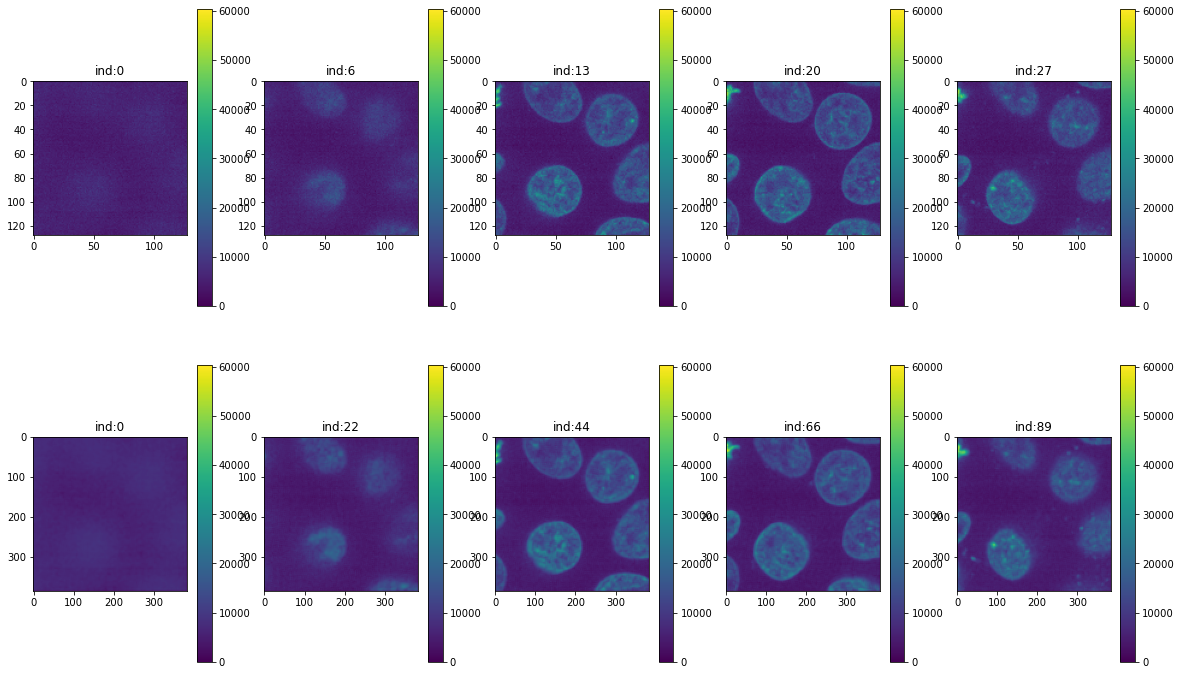

In [9]:
scale = 3
volume_interpolated = spline_model.render(scale).detach().numpy()

vmin = min(volume.min(), volume_interpolated.min())
vmax = max(volume.max(), volume_interpolated.max())

n = 5
fig, axes = subplots(2, n, figsize=(n*4, 3*4))
for i, j in enumerate(np.linspace(0, volume.shape[2]-scale, n)):
    j = int(floor(j))
    im=axes[0,i].imshow(volume[:,:,j], vmin=vmin, vmax=vmax)
    colorbar(im, ax=axes[0,i])
    axes[0,i].set_title("ind:{}".format(j))
    
for i, j in enumerate(np.linspace(0, volume_interpolated.shape[2]-1, n)):
    j = int(floor(j))
    im=axes[1,i].imshow(volume_interpolated[:,:,j], vmin=vmin, vmax=vmax)
    colorbar(im, ax=axes[1,i])
    axes[1,i].set_title("ind:{}".format(j))

In [10]:
reload(renderer)
print(volume.shape)
padding = 16
spline_model = renderer.Spline3DRenderer([dim+2*padding for dim in volume.shape[:2]], [], k=3, template_init=volume)

(128, 128, 30)


  0%|          | 0/10 [00:00<?, ?it/s]

Final loss: 579780.625	R2: 0.979


(128, 128, 30)


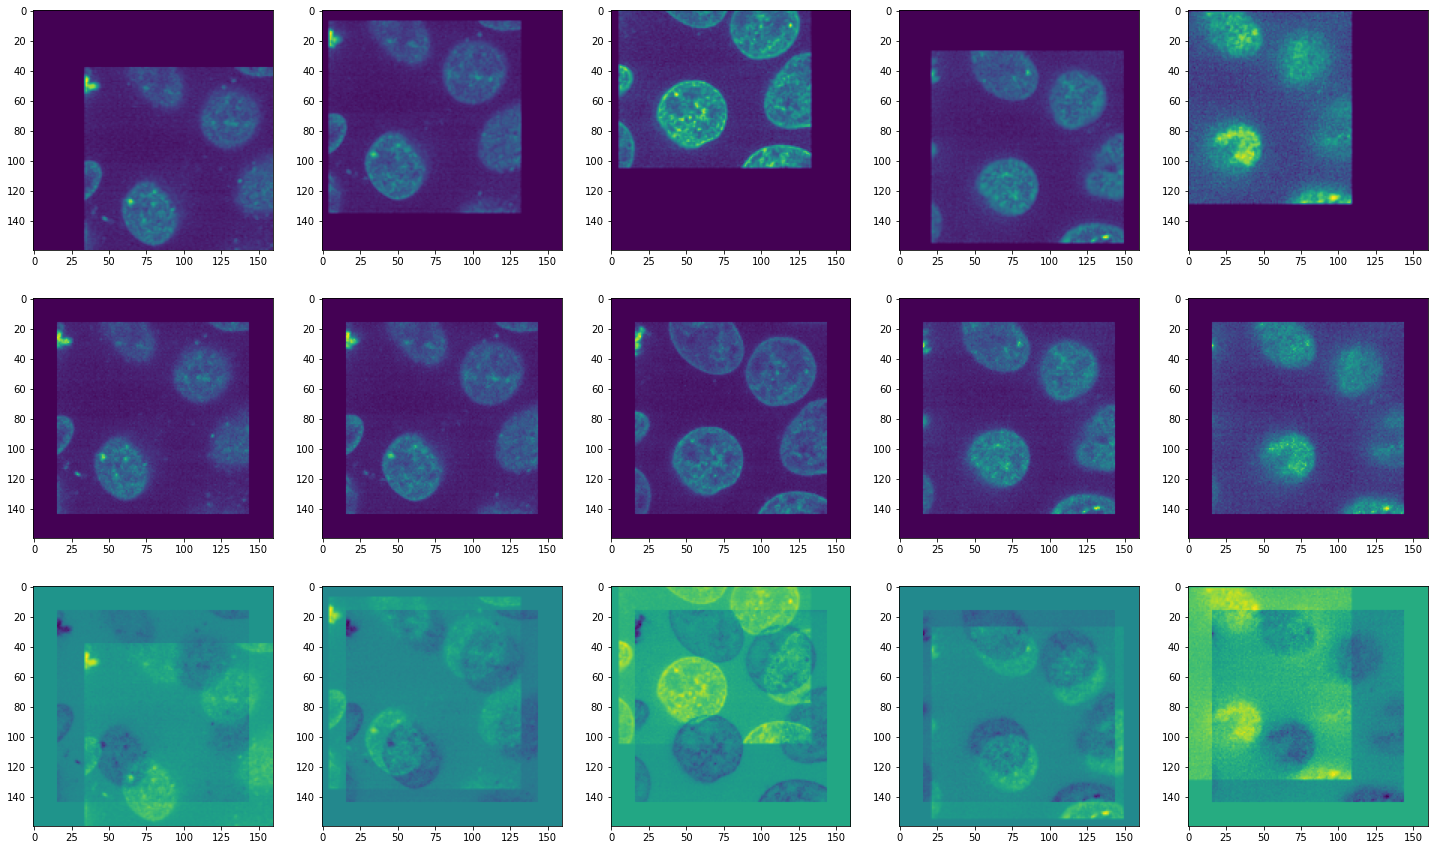

In [11]:
print(volume.shape)

x = dict()
x['x'] = (torch.rand((128, 1, 1, 1)) - 0.5) * 2 * 50
x['y'] = (torch.rand((128, 1, 1, 1)) - 0.5) * 2 * 50
x['z'] = torch.rand((128, 1, 1, 1)) * volume.shape[2] - volume.shape[2]//2
x['A'] = 1
x['bg'] = 0
volume_interpolated = spline_model(x).detach().numpy()

n = 5
fig, axes = subplots(3, n, figsize=(5*n, 5*3))
for i, j in enumerate(np.linspace(0, volume_interpolated.shape[0]-1, n)):
    j = int(floor(j))
    
    axes[0,i].imshow(volume_interpolated[j,0,:,:])
    z_index = min(int(floor(x['z'][j] + volume.shape[2]//2)), volume.shape[2]-1)
    groundtruth = np.pad(volume[:,:,z_index], ((padding,)*2, (padding,)*2))
    axes[1,i].imshow(groundtruth)
    axes[2,i].imshow(volume_interpolated[j,0,:,:]-groundtruth)

In [12]:
reload(renderer)
print(volume.shape)
padding = 16
spline_model = renderer.Spline3DRenderer(volume.shape[:2], [], k=3, template_init=volume[:32,:32])

x = dict()
x['x'] = (torch.rand((1024, 1, 1, 1)) - 0.5) * 2 * 50
x['y'] = (torch.rand((1024, 1, 1, 1)) - 0.5) * 2 * 50
x['z'] = torch.rand((1024, 1, 1, 1)) * volume.shape[2]
x['A'] = 1
x['bg'] = 0

%timeit volume_interpolated = spline_model(x)

(128, 128, 30)


  0%|          | 0/10 [00:00<?, ?it/s]

Final loss: 847423.438	R2: 0.982
895 ms ± 55.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
